In [ ]:
pip install spotipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.2/261.2 kB 7.3 MB/s eta 0:00:00


In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd

# Autenticación con la API de Spotify
client_credentials_manager = SpotifyClientCredentials(client_id='Client ID', client_secret='Client secret')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

def get_artist_data(artist_name):
    result = sp.search(q='artist:' + artist_name, type='artist')
    artist = result['artists']['items'][0]
    return artist
# Función para obtener datos de canciones de un artista
def get_track_data(artist_name, total_songs=100, limit=50):
    # Inicializamos la lista para almacenar los datos de las canciones
    track_data = []

    # Número total de canciones recuperadas
    retrieved_songs = 0

    while retrieved_songs < total_songs:
        # Realizamos la búsqueda
        result = sp.search(q=artist_name, type='track', limit=limit, offset=retrieved_songs)

        # Si no hay más canciones, rompemos el bucle
        if not result['tracks']['items']:
            break

        # Recorremos las canciones obtenidas
        for track in result['tracks']['items']:
          track_info = sp.audio_features(track['id'])[0]
          if track_info:
            track_data.append({
                    'name': track['name'],
                    'artist': track['artists'][0]['name'],
                    'popularity': track['popularity'],
                    'danceability': track_info['danceability'],
                    'energy': track_info['energy'],
                    'tempo': track_info['tempo'],
                    'duration_ms': track_info['duration_ms'],
                    'valence': track_info['valence'],
                    'explicit': track['explicit']
                })

        # Incrementamos el número de canciones recuperadas
        retrieved_songs += len(result['tracks']['items'])

    return pd.DataFrame(track_data)


artist_name = 'Coldplay'
artist_info = get_artist_data(artist_name)
df_tracks = get_track_data(artist_name, total_songs=200)  # Puedes ajustar el número total de canciones

print("Información del Artista:")
print(artist_info)
print("\nDatos de Canciones:")
print(df_tracks.head())

Información del Artista:
{'external_urls': {'spotify': 'https://open.spotify.com/artist/790FomKkXshlbRYZFtlgla'}, 'followers': {'href': None, 'total': 50734792}, 'genres': ['reggaeton', 'reggaeton colombiano', 'urbano latino'], 'href': 'https://api.spotify.com/v1/artists/790FomKkXshlbRYZFtlgla', 'id': '790FomKkXshlbRYZFtlgla', 'images': [{'height': 640, 'url': 'https://i.scdn.co/image/ab6761610000e5eb4b0754aefc9db490e02205ec', 'width': 640}, {'height': 320, 'url': 'https://i.scdn.co/image/ab676161000051744b0754aefc9db490e02205ec', 'width': 320}, {'height': 160, 'url': 'https://i.scdn.co/image/ab6761610000f1784b0754aefc9db490e02205ec', 'width': 160}], 'name': 'KAROL G', 'popularity': 92, 'type': 'artist', 'uri': 'spotify:artist:790FomKkXshlbRYZFtlgla'}

Datos de Canciones:
                           name   artist  popularity  danceability  energy  \
0  Si Antes Te Hubiera Conocido  KAROL G          95         0.924   0.668   
1                         QLONA  KAROL G          86         

In [ ]:
# Convertimos la columna 'explicit' a binaria y creamos una nueva columna 'is_success' (éxito)
df_tracks['explicit'] = df_tracks['explicit'].astype(int)
df_tracks['is_success'] = df_tracks['popularity'].apply(lambda x: 1 if x > 70 else 0)  # Canciones con popularidad >70 son éxitos

# Normalización de datos (preprocesamiento para k-means)
from sklearn.preprocessing import StandardScaler

features = ['danceability', 'energy', 'tempo', 'valence', 'explicit']
scaler = StandardScaler()
df_tracks_scaled = scaler.fit_transform(df_tracks[features])


# Regresión Logística:
Aplicamos un modelo de regresión logística para predecir si una canción será exitosa.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Variables independientes y dependientes
X = df_tracks[['danceability', 'energy', 'tempo', 'valence', 'explicit']]
y = df_tracks['is_success']

# Dividimos los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenamos el modelo de regresión logística
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Predicciones
y_pred = logreg.predict(X_test)

# Evaluación del modelo
print(f"Precisión: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))


Precisión: 0.85
              precision    recall  f1-score   support

           0       0.85      1.00      0.92        34
           1       0.00      0.00      0.00         6

    accuracy                           0.85        40
   macro avg       0.42      0.50      0.46        40
weighted avg       0.72      0.85      0.78        40



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.85      0.45      0.59        51
           1       0.15      0.56      0.24         9

    accuracy                           0.47        60
   macro avg       0.50      0.50      0.41        60
weighted avg       0.75      0.47      0.54        60



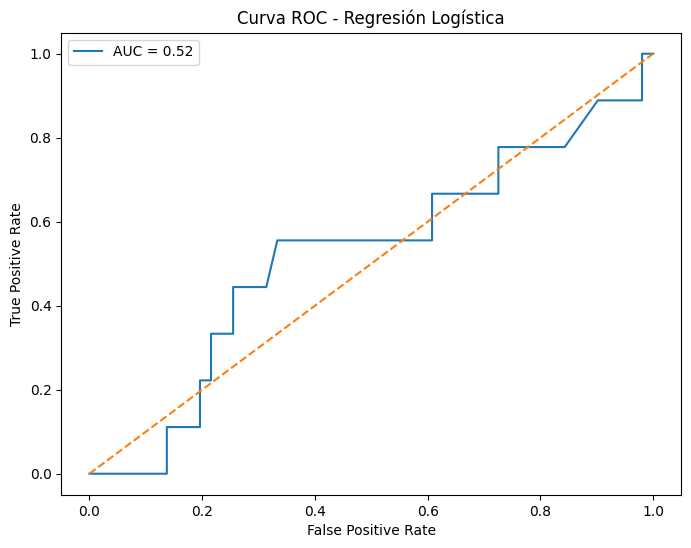

       Variable  Coeficiente
0  danceability     0.802851
1        energy     0.668832
3       valence     0.136160
2         tempo    -0.010082
4      explicit    -1.288008


In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, classification_report

# Separar características y variable objetivo
X = df_tracks[['danceability', 'energy', 'tempo', 'valence', 'explicit']]
y = df_tracks['is_success']

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Aplicar SMOTE para balancear las clases
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Ajustar modelo de regresión logística
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
logreg.fit(X_train_bal, y_train_bal)

# Predicción en el conjunto de prueba
y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:, 1]  # Probabilidad de éxito

# Evaluación del modelo
print(classification_report(y_test, y_pred))
roc_auc = roc_auc_score(y_test, y_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Curva ROC
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Regresión Logística')
plt.legend()
plt.show()

# Mostrar coeficientes del modelo para interpretar la importancia de las características
import numpy as np
coefs = pd.DataFrame({'Variable': X.columns, 'Coeficiente': logreg.coef_[0]})
print(coefs.sort_values(by='Coeficiente', ascending=False))


# Análisis de Clúster (K-means):
Usamos el algoritmo k-means para agrupar canciones según sus características musicales.

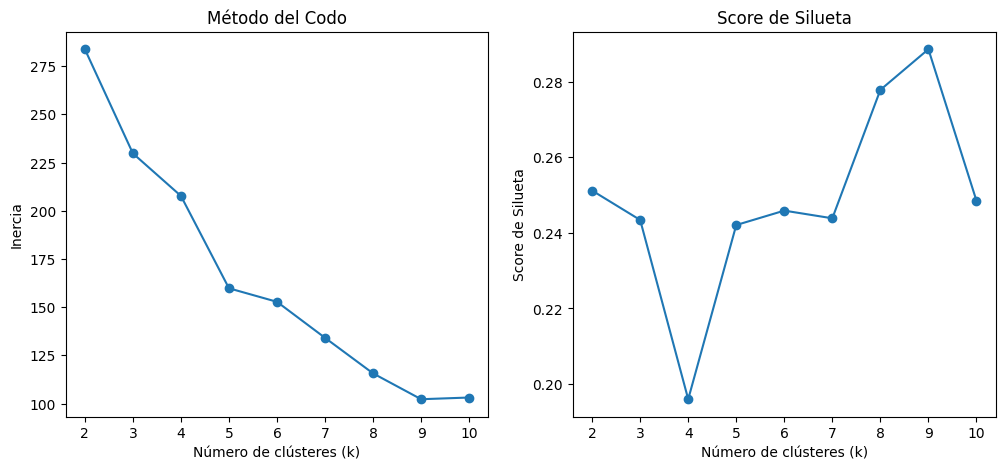

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_tracks[['danceability', 'energy', 'tempo', 'valence']])

# Método del codo para elegir el número óptimo de clústeres
inertia = []
silhouette_scores = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Graficar el método del codo y el score de silueta
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Número de clústeres (k)')
plt.ylabel('Inercia')
plt.title('Método del Codo')

plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker='o')
plt.xlabel('Número de clústeres (k)')
plt.ylabel('Score de Silueta')
plt.title('Score de Silueta')

plt.show()




/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

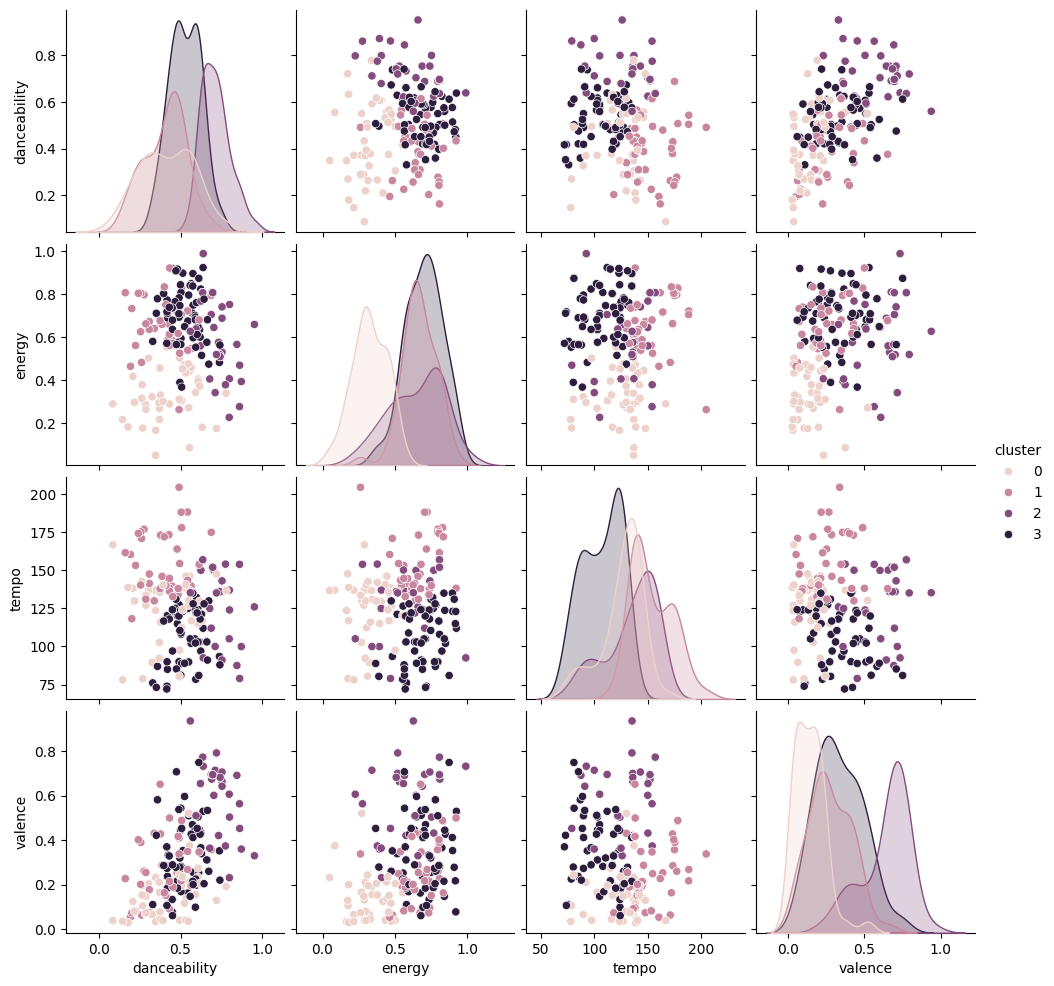

In [ ]:
# Elegir el número óptimo de clústeres basado en los resultados
optimal_k = 4  # Ejemplo: puedes cambiar esto según los gráficos

# Aplicar k-means con el número óptimo de clústeres
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_tracks['cluster'] = kmeans.fit_predict(X_scaled)

# Visualización de los clústeres
import seaborn as sns
sns.pairplot(df_tracks, hue='cluster', vars=['danceability', 'energy', 'tempo', 'valence'])
plt.show()

In [ ]:
# Añadimos los clústeres a la tabla original
df_tracks['cluster'] = kmeans.labels_

# Seleccionamos las columnas relevantes para la tabla final
df_cluster_table = df_tracks[['name', 'artist', 'popularity', 'danceability', 'energy', 'tempo', 'valence', 'cluster']]

# Mostramos los primeros registros de la tabla
print(df_cluster_table.head())

# Exportar a un archivo CSV si es necesario para su análisis:
df_cluster_table.to_csv('songs_cluster_table.csv', index=False)


           name    artist  popularity  danceability  energy    tempo  valence  \
0  Viva La Vida  Coldplay          86         0.486   0.617  138.015    0.417   
1        Yellow  Coldplay          90         0.429   0.661  173.372    0.285   
2        Clocks  Coldplay          82         0.577   0.749  130.970    0.255   
3        Sparks  Coldplay          85         0.371   0.268  102.617    0.165   
4      Paradise  Coldplay          82         0.449   0.585  139.631    0.212   

   cluster  
0        1  
1        1  
2        3  
3        0  
4        1  


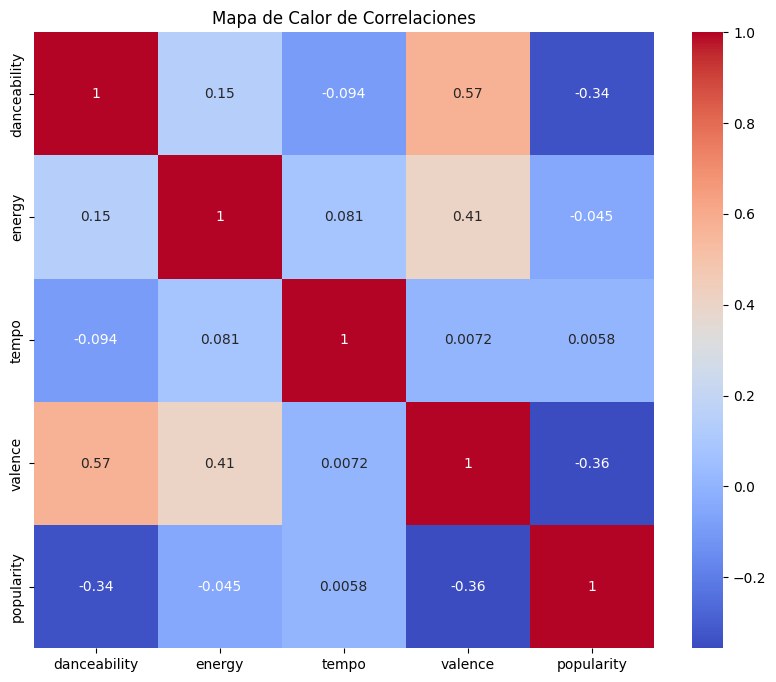

In [ ]:
import seaborn as sns
import numpy as np

# Mapa de calor para ver las correlaciones entre variables
plt.figure(figsize=(10, 8))
sns.heatmap(df_tracks[['danceability', 'energy', 'tempo', 'valence', 'popularity']].corr(), annot=True, cmap='coolwarm')
plt.title('Mapa de Calor de Correlaciones')
plt.show()


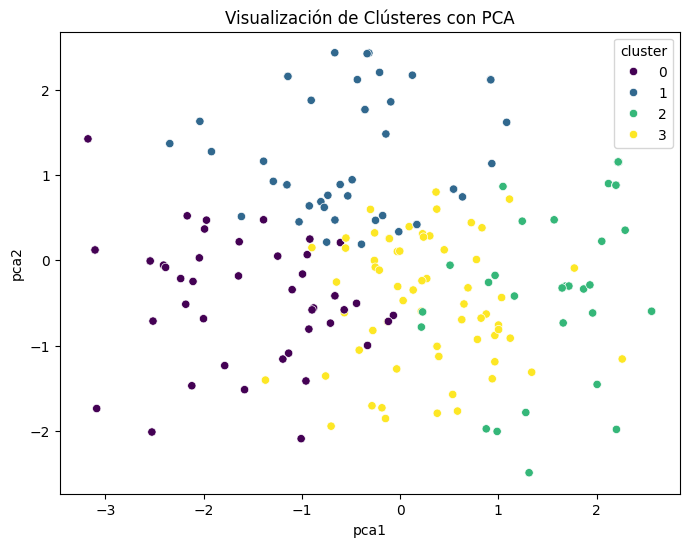

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


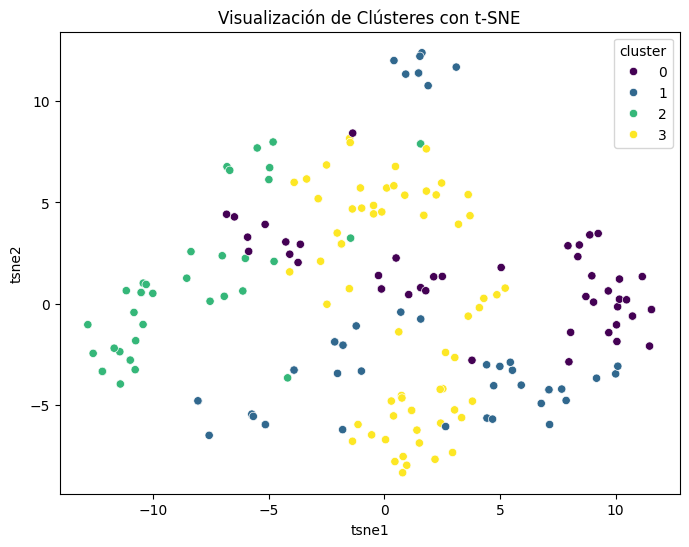

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# PCA para reducir a 2 dimensiones y visualizar clústeres
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

df_tracks['pca1'] = pca_result[:, 0]
df_tracks['pca2'] = pca_result[:, 1]

# Visualización de los clústeres en el espacio PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x='pca1', y='pca2', hue='cluster', data=df_tracks, palette='viridis')
plt.title('Visualización de Clústeres con PCA')
plt.show()

# Alternativa: Visualización con t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, random_state=42)
tsne_result = tsne.fit_transform(X_scaled)

df_tracks['tsne1'] = tsne_result[:, 0]
df_tracks['tsne2'] = tsne_result[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(x='tsne1', y='tsne2', hue='cluster', data=df_tracks, palette='viridis')
plt.title('Visualización de Clústeres con t-SNE')
plt.show()
